In [1]:
# Import routines
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import glob

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

import pandas as pd

In [2]:
# Definitions

def Transform_NASAWorldview_Geotiff(file):
    # spatial reference system of cartopy maps
    target_proj = ccrs.NorthPolarStereo(central_longitude=10)
    #print(file)
    file_out = file.replace(".tif", "_reprojected.tiff")
    gdal.Warp(file_out,
              file,
              dstSRS = target_proj.proj4_init)
    print(file_out)
    return file_out


def read_worldview_reprojected(file):
    img = gdal.Open(file)
    data = img.ReadAsArray()
    # make background from black to white
    ix = data.sum(axis=0) == 0
    data[..., ix] = 255
    # get extent
    gt = img.GetGeoTransform()
    extent = (gt[0], gt[0] + img.RasterXSize * gt[1],
              gt[3] + img.RasterYSize * gt[5], gt[3])
    data = data.transpose((1, 2, 0))
    return data, extent

In [3]:
# Transform snapshot from Nasa Worldview to Cartopy maps format

file = "/Users/marcusklingebiel/Documents/Projects/14_HAWK_HALO-AC3/20220404_Analysis/Flighttrack_and_maps/snapshot-2022-04-04T00_00_00Z.tif"
file_trans = Transform_NASAWorldview_Geotiff(file)

/Users/marcusklingebiel/Documents/Projects/14_HAWK_HALO-AC3/20220404_Analysis/Flighttrack_and_maps/snapshot-2022-04-04T00_00_00Z_reprojected.tiff


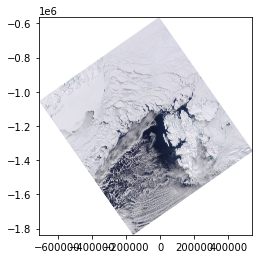

In [4]:
#Load reprojected GeoTiff Image

file = file_trans
img, extent = read_worldview_reprojected(file)

plt.imshow(img,extent=extent, origin='upper')

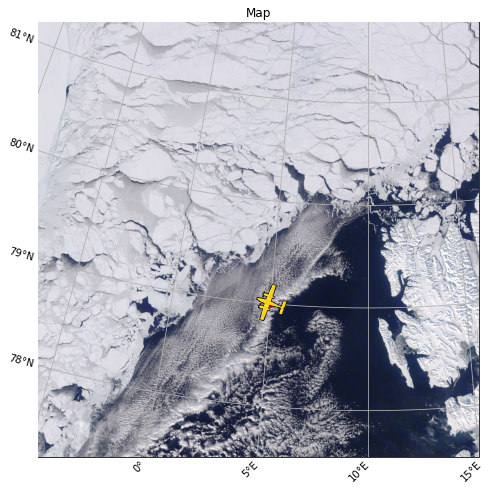

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

# Assume 'img' and 'extent' are defined elsewhere in your actual script
# For this example, let's create a dummy img and extent
#img = np.random.rand(100, 100)
#extent = [-5, 15, 77.5, 81.5]

# Plot satellite picture on map
plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=10))
ax.set_extent([-5, 15, 77.5, 81.5], crs=ccrs.PlateCarree())

ax.coastlines(resolution='10m')
ax.imshow(img, extent=extent, origin='upper', zorder=10, alpha=1)

#---------------------------------------------------
# Plot flight track (example - uncomment if you have data)
# lon_halo = [...]
# lat_halo = [...]
# ax.plot(lon_halo,lat_halo,
#          color='blue', linewidth=1,
#          transform=ccrs.PlateCarree(),
#          label="HALO"
#          )

# Plot dropsondes (example - uncomment if you have data)
# ls_ds_lon = [...]
# ls_ds_lat = [...]
# ax.scatter(ls_ds_lon,ls_ds_lat, marker="+", transform=ccrs.PlateCarree(), color="brown", zorder=3)
#---------------------------------------------------


#---------------------------------------------------
# Load your aircraft icon
icon_path = "/Users/marcusklingebiel/Documents/Supervision/WinterSchool_Finnland_2025/python_scripts/174299820111956910.png"
try:
    icon = Image.open(icon_path)
except FileNotFoundError:
    print(f"Error: Icon file not found at {icon_path}")
    exit()




# Define the position in PlateCarree coordinates
lon, lat = 5, 79

# Define aircraft heading in degrees (0° = North, 90° = East, etc.)
heading = 290  # Change this to the desired heading

# Rotate the icon (expand=True prevents cropping)
rotated_icon = icon.rotate(-heading, resample=Image.BICUBIC, expand=True)  # negative to rotate clockwise

# Convert rotated image to matplotlib format
ic = OffsetImage(rotated_icon, zoom=0.5)



# Transform the PlateCarree coordinates to the axes' projection
x_proj, y_proj = ax.projection.transform_point(lon, lat, ccrs.PlateCarree())

# Wrap it in AnnotationBbox with the *projected* coordinates
ab = AnnotationBbox(
    ic,
    (x_proj, y_proj),
    frameon=False,  # Set to False to remove the frame
    transform=ax.transData,  # Now the coordinates are in the axes' projection
    zorder=20
)

# Add to axes
ax.add_artist(ab)

# Mark the position with a red dot (still in PlateCarree for reference)
ax.plot(lon, lat, marker='o', color='red', transform=ccrs.PlateCarree(), zorder=20)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, zorder = 20)
gl.xlabel_style = {'rotation': 45}

gl.top_labels = False
gl.right_labels = False

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Map")
plt.show()